<a href="https://colab.research.google.com/github/kakashi3lite/GeoAirQuality/blob/main/GeoAirQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np



In [42]:
pip install prophet

In [43]:
from prophet import Prophet

Step 1: Load Dataset

In [44]:
file_path = 'https://raw.githubusercontent.com/kakashi3lite/GeoAirQuality/refs/heads/main/GlobalWeatherRepository.csv'
weather_data = pd.read_csv(file_path)

Step 2: Preprocessing


In [45]:
weather_data['last_updated'] = pd.to_datetime(weather_data['last_updated'])

In [46]:
weather_data.set_index('last_updated', inplace=True)

In [47]:
time_series_data = weather_data[['temperature_celsius', 'air_quality_PM2.5']]

Step 3: Handle Missing Data

In [48]:
time_series_data.fillna(method='ffill', inplace=True)

<ipython-input-48-dd373fe95cad>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_data.fillna(method='ffill', inplace=True)
<ipython-input-48-dd373fe95cad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_data.fillna(method='ffill', inplace=True)


Step 4: Exploratory Data Analysis

Temperature Trends

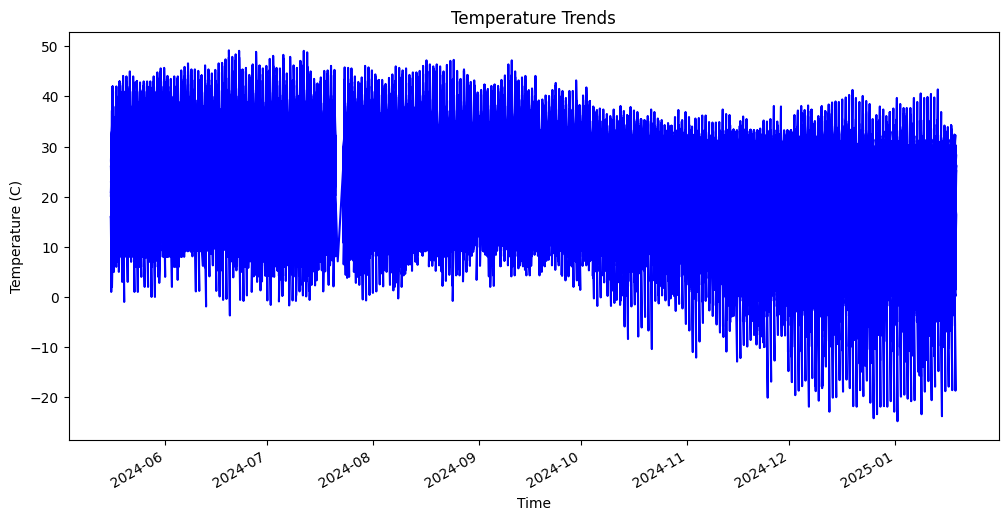

In [49]:
plt.figure(figsize=(12, 6))
time_series_data['temperature_celsius'].plot(title='Temperature Trends', ylabel='Temperature (C)', xlabel='Time', color='blue')
plt.show()

Air Quality Trends

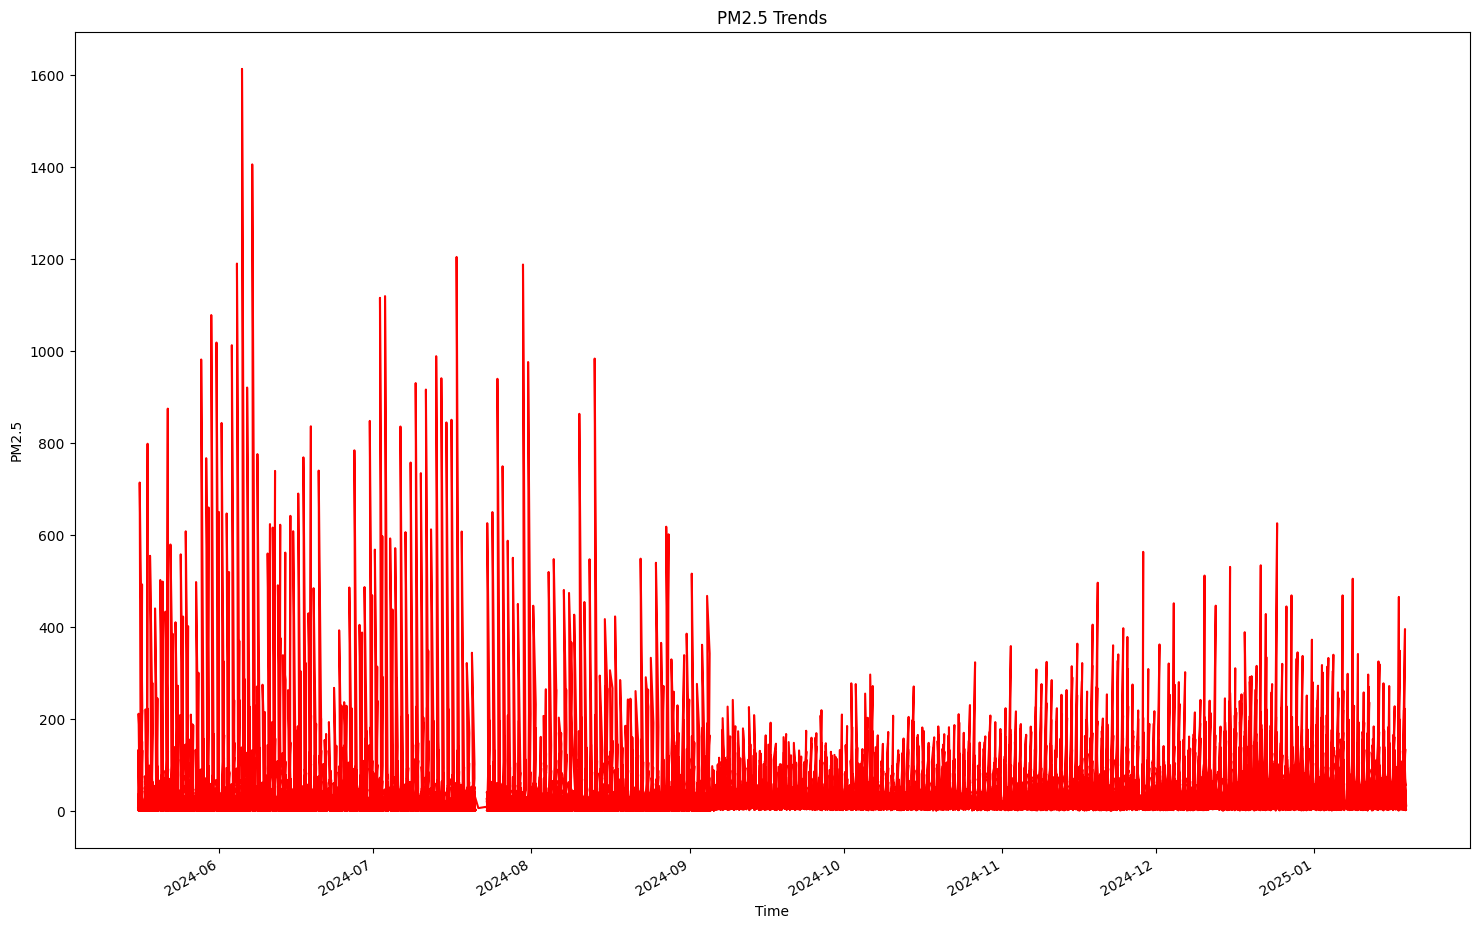

In [50]:
plt.figure(figsize=(18, 12))
time_series_data['air_quality_PM2.5'].plot(title='PM2.5 Trends', ylabel='PM2.5', xlabel='Time', color='red')
plt.show()

Step 5: Time Series Analysis

In [51]:
prophet_df = time_series_data.reset_index()[['last_updated', 'temperature_celsius']]
prophet_df.columns = ['ds', 'y']


In [52]:
prophet_model = Prophet()
prophet_model.fit(prophet_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwfh6dem6/cwwo6042.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwfh6dem6/vyl4__61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69309', 'data', 'file=/tmp/tmpwfh6dem6/cwwo6042.json', 'init=/tmp/tmpwfh6dem6/vyl4__61.json', 'output', 'file=/tmp/tmpwfh6dem6/prophet_model77ylk013/prophet_model-20250118193236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [53]:
future_dates = prophet_model.make_future_dataframe(periods=30, freq='D')
forecast = prophet_model.predict(future_dates)

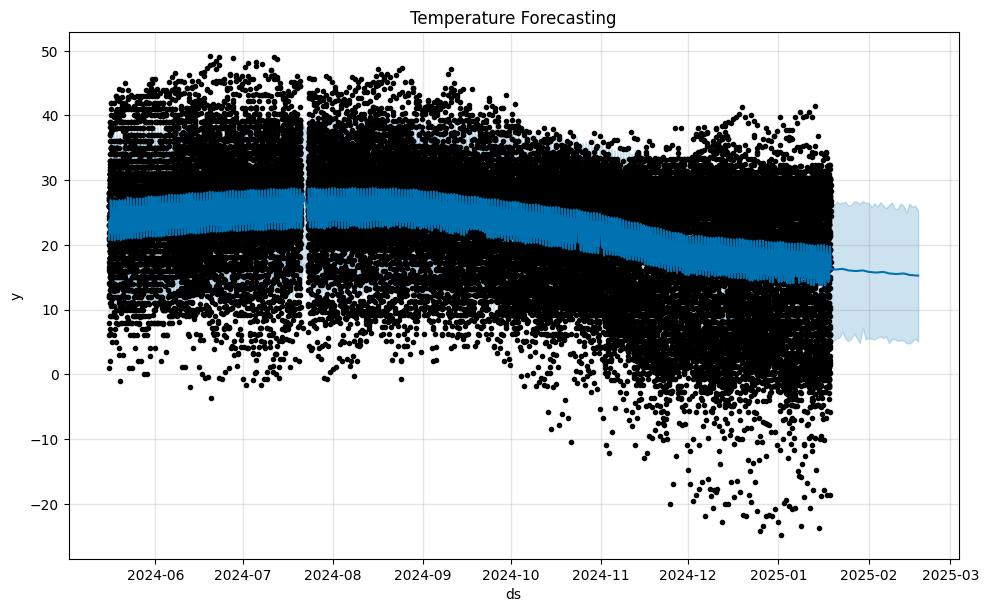

In [55]:
prophet_model.plot(forecast)
plt.title('Temperature Forecasting')
plt.show()

Using ARIMA for Air Quality Prediction

In [56]:
series = time_series_data['air_quality_PM2.5']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

In [57]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:      air_quality_PM2.5   No. Observations:                47941
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -254466.157
Date:                Sat, 18 Jan 2025   AIC                         508944.314
Time:                        19:34:28   BIC                         508996.980
Sample:                             0   HQIC                        508960.844
                              - 47941                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7406      0.002   -444.057      0.000      -0.744      -0.737
ar.L2         -0.5903      0.002   -268.248      0.000      -0.595      -0.586
ar.L3         -0.4499      0.002   -183.664      0.0

Forecasting Air Quality


In [58]:
forecast_steps = 30
forecast_values = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=series.index[-1], periods=forecast_steps + 1, freq='D')[1:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


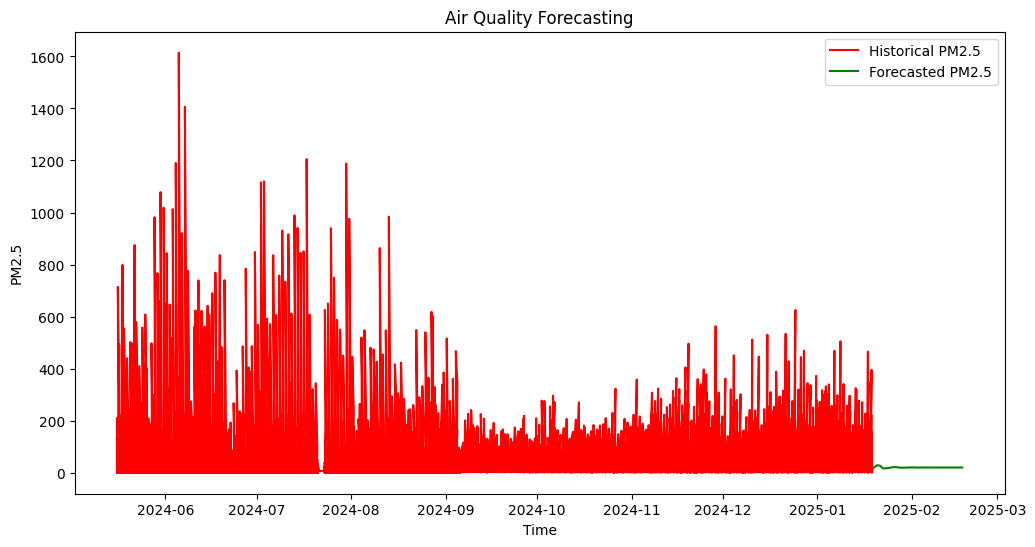

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(series, label='Historical PM2.5', color='red')
plt.plot(forecast_index, forecast_values, label='Forecasted PM2.5', color='green')
plt.title('Air Quality Forecasting')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

Step 6: Fitting the Model


In [60]:
train, test = series[:-30], series[-30:]
predicted = model_fit.forecast(steps=30)
mse = mean_squared_error(test, predicted)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 999.9798289103569


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Step 7: Let's Visualize

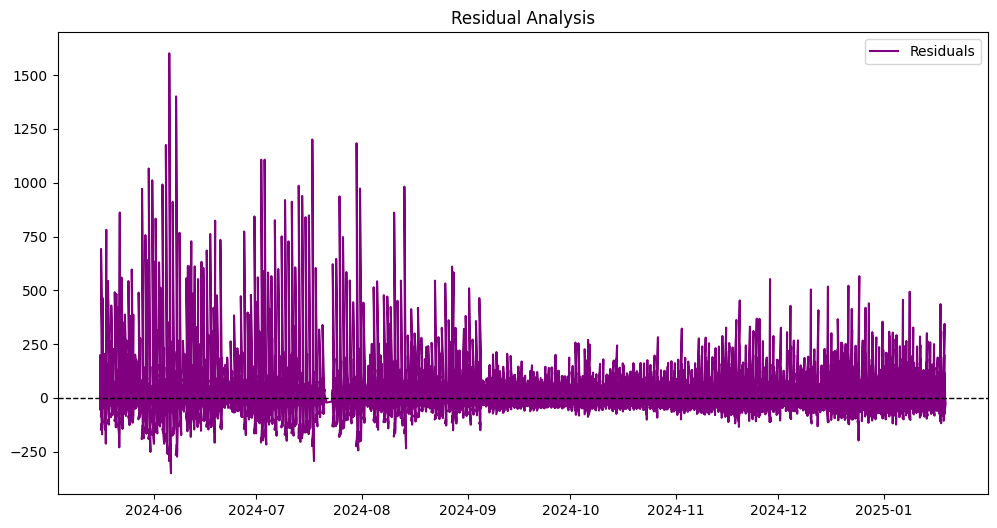

In [61]:
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Residual Analysis')
plt.legend()
plt.show()

Temperature Heatmap

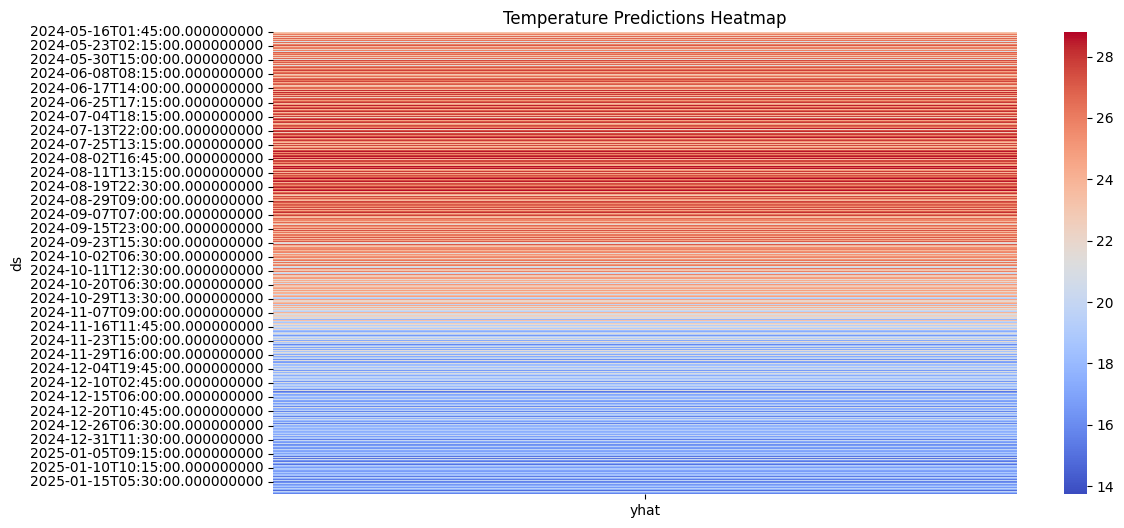

In [62]:
plt.figure(figsize=(12, 6))
sns.heatmap(forecast[['ds', 'yhat']].pivot_table(index='ds', values='yhat'), cmap='coolwarm', cbar=True)
plt.title('Temperature Predictions Heatmap')
plt.show()

In [63]:
forecast.to_csv('forecasted_temperature.csv', index=False)